In [2]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(1234)

In [3]:
matplotlib.rcParams.update({'font.size': 16})

# Within-County Regression

In [5]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
idxs = data[:, 0]
data = data[:, 1:]
data[:, 3] = data[:, 3] + data[:, 2]
data = data[:, 3:]
print(idxs.shape, data.shape)

(3093,) (3093, 4)


In [6]:
feature_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

% some college or greater 51.71008729388942 10.638378042881463
% in poverty 15.390300678952473 6.245691926695084
% unemployed 4.556870352408665 1.5675094387631234


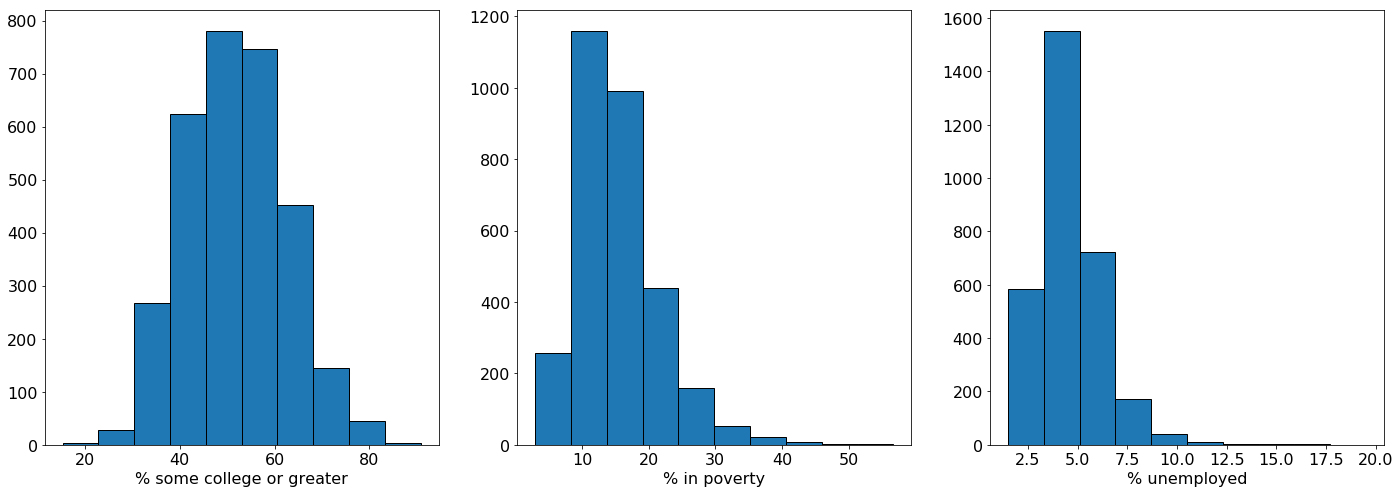

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
idx = 0
for i in [1, 3, 4]:
    print(feature_to_name[i], np.mean(data[:, i - 1]), np.std(data[:, i - 1]))
    axes[idx].hist(data[:, i - 1], edgecolor='black')
    axes[idx].set_xlabel(feature_to_name[i])
    idx += 1
plt.show()

## Baseline: Use mean of each feature in training set

In [18]:
def baseline(data, num_folds=5, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        y = data[:, label]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            y_pred = np.array([np.mean(y_train)] * len(y_test))
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(feature_to_name[label + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [19]:
baseline(data)


=== % some college or greater ===
Mean Squared Error: mean = 113.26990843787814, median = 116.38549446929802, std = 5.455845780614538, min = 103.4575691924363, max = 118.55253002967949
Mean Absolute Error: mean = 8.625020645384636, median = 8.710543383008817, std = 0.26286909935308966, min = 8.22258958517211, max = 8.898037032635369
Label stats: min = 15.3, max = 90.8, mean = 51.71008729388942, std = 10.638378042881463

=== % in poverty ===
Mean Squared Error: mean = 39.0452558638413, median = 38.443387109902595, std = 3.048639302374546, min = 35.09067157713053, max = 42.71644089954392
Mean Absolute Error: mean = 4.743236096427919, median = 4.654315125363669, std = 0.14987474385044622, min = 4.585279395900756, max = 4.935310231251543
Label stats: min = 3.0, max = 56.7, mean = 15.390300678952473, std = 6.245691926695084

=== % unemployed ===
Mean Squared Error: mean = 2.459206058581443, median = 2.3683195539116917, std = 0.3265026556698756, min = 2.178438524335242, max = 3.092293615571

## Regression using within-county features

In [123]:
def do_regression(data, num_folds=5, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        # This does z-score normalization of data
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        y = data[:, label]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(feature_to_name[label + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [124]:
do_regression(data)


=== % some college or greater ===
Mean Squared Error: mean = 71.42953510583877, median = 70.90388508031926, std = 8.910002168362329, min = 58.68196649225366, max = 85.69738365058515
Mean Absolute Error: mean = 6.549494566871806, median = 6.5425416640528065, std = 0.3100061945847617, min = 6.026671635954233, max = 6.910694394511221
Label stats: min = 15.3, max = 90.8, mean = 51.71008729388942, std = 10.638378042881463

=== % in poverty ===
Mean Squared Error: mean = 20.669302412904507, median = 20.739644272278923, std = 1.6022669630452953, min = 17.877650677496977, max = 22.69606586639621
Mean Absolute Error: mean = 3.3330070582886955, median = 3.306425732534178, std = 0.06059309867065745, min = 3.249294677643827, max = 3.4053375446233356
Label stats: min = 3.0, max = 56.7, mean = 15.390300678952473, std = 6.245691926695084

=== % unemployed ===
Mean Squared Error: mean = 1.6050542189134913, median = 1.4720478213663863, std = 0.28754233537609164, min = 1.2977195786269138, max = 2.12573

Note that I also tried Ridge and Lasso regression and neither improved performance. Our task isn't complex enough to require regularization.

In [9]:
def plot_concordance(data, labels=None, seed=1234):
    if labels is None:
        labels = np.arange(data.shape[1])
        
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for label in labels:
        if feature_to_name[label + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        data_idxs = np.delete(np.arange(data.shape[1]), label)
        x = data[:, data_idxs]
        # This does z-score normalization of data
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        y = data[:, label]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(feature_to_name[label + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            axes[1, idx].set_xticklabels([''] + [feature_to_name[i + 1] for i in data_idxs])
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

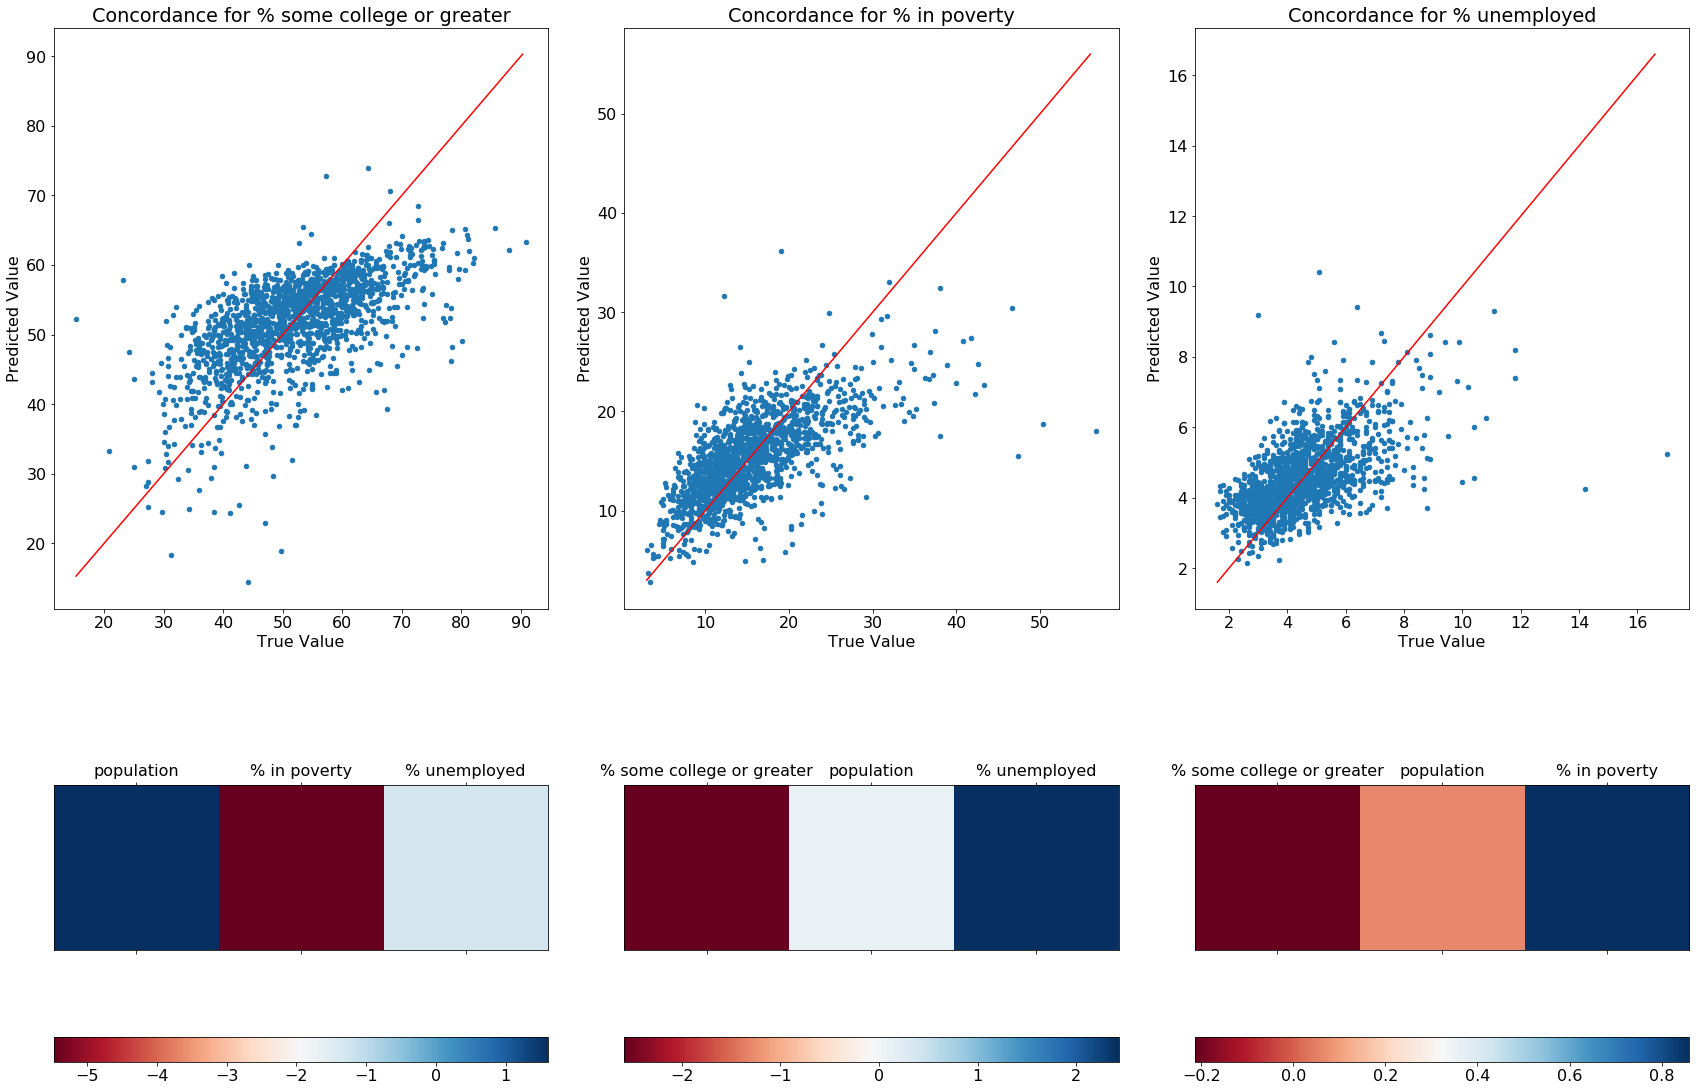

In [10]:
plot_concordance(data)

# Neighbor Regression

In [24]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
adj_list = pickle.load(open('data/processed_data/adj_list', 'rb'))
idxs = data[:, 0]

neighbor_data = []
labels = []
for i in idxs:
    if i not in adj_list:
        continue
    
    # Prepare within-county labels
    label_data = data[idxs == i][0][1:]
    label_data[3] = label_data[3] + label_data[2]
    label_data = label_data[3:]
    labels.append(label_data)
    
    # Prepare neighbor-county features
    neighbors = adj_list[i]
    neighbor_attributes = []
    for n in neighbors:
        if n not in idxs:
            continue
        d = data[idxs == n][0][1:]
        d[3] = d[3] + d[2]
        d = d[3:]
        neighbor_attributes.append(d)
    neighbor_attributes = np.array(neighbor_attributes)
    min_attributes = np.min(neighbor_attributes, axis=0)
    max_attributes = np.max(neighbor_attributes, axis=0)
    mean_attributes = np.mean(neighbor_attributes, axis=0)
    std_attributes = np.std(neighbor_attributes, axis=0)
    feature_vec = np.concatenate((min_attributes, max_attributes, mean_attributes, std_attributes, np.array([len(neighbors)])))
    neighbor_data.append(feature_vec)
    
neighbor_data = np.array(neighbor_data)
labels = np.array(labels)
print(neighbor_data.shape, labels.shape)

(3091, 17) (3091, 4)


In [67]:
label_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

feature_to_name = {
    0: 'min education',
    1: 'min population',
    2: 'min poverty',
    3: 'min unemployment',
    4: 'max education',
    5: 'max population',
    6: 'max poverty',
    7: 'max unemployment',
    8: 'mean education',
    9: 'mean population',
    10: 'mean poverty',
    11: 'mean unemployment',
    12: 'std education',
    13: 'std population',
    14: 'std poverty',
    15: 'std unemployment',
    16: 'number of neighbors'
}

In [59]:
def do_regression(data, labels, num_folds=5, seed=1234):        
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        y = labels[:, i]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(label_to_name[i + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [60]:
do_regression(neighbor_data, labels)


=== % some college or greater ===
Mean Squared Error: mean = 41.285669428919576, median = 42.498640490610306, std = 4.205404182875987, min = 33.32957986173438, max = 45.83450580262418
Mean Absolute Error: mean = 4.887054053611978, median = 4.989657144347664, std = 0.21534739136446104, min = 4.466394555640559, max = 5.036273239684356
Label stats: min = 15.3, max = 90.8, mean = 51.71015852474927, std = 10.639074817876304

=== % in poverty ===
Mean Squared Error: mean = 11.851220537503279, median = 12.125406854803469, std = 0.8806313943479562, min = 10.2570744244699, max = 12.892832391937478
Mean Absolute Error: mean = 2.45969579182361, median = 2.462926967799789, std = 0.06456652115360244, min = 2.3634160025882425, max = 2.5561102779105704
Label stats: min = 3.0, max = 56.7, mean = 15.393303138142995, std = 6.246585903489967

=== % unemployed ===
Mean Squared Error: mean = 0.6879469835949451, median = 0.5804805900316226, std = 0.2115466604803354, min = 0.45306980016701504, max = 0.94705

In [61]:
def plot_concordance(data, labels, seed=1234):
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        y = labels[:, i]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(label_to_name[i + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            axes[1, idx].set_xticks(np.arange(0, 17))
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

(3091, 17)


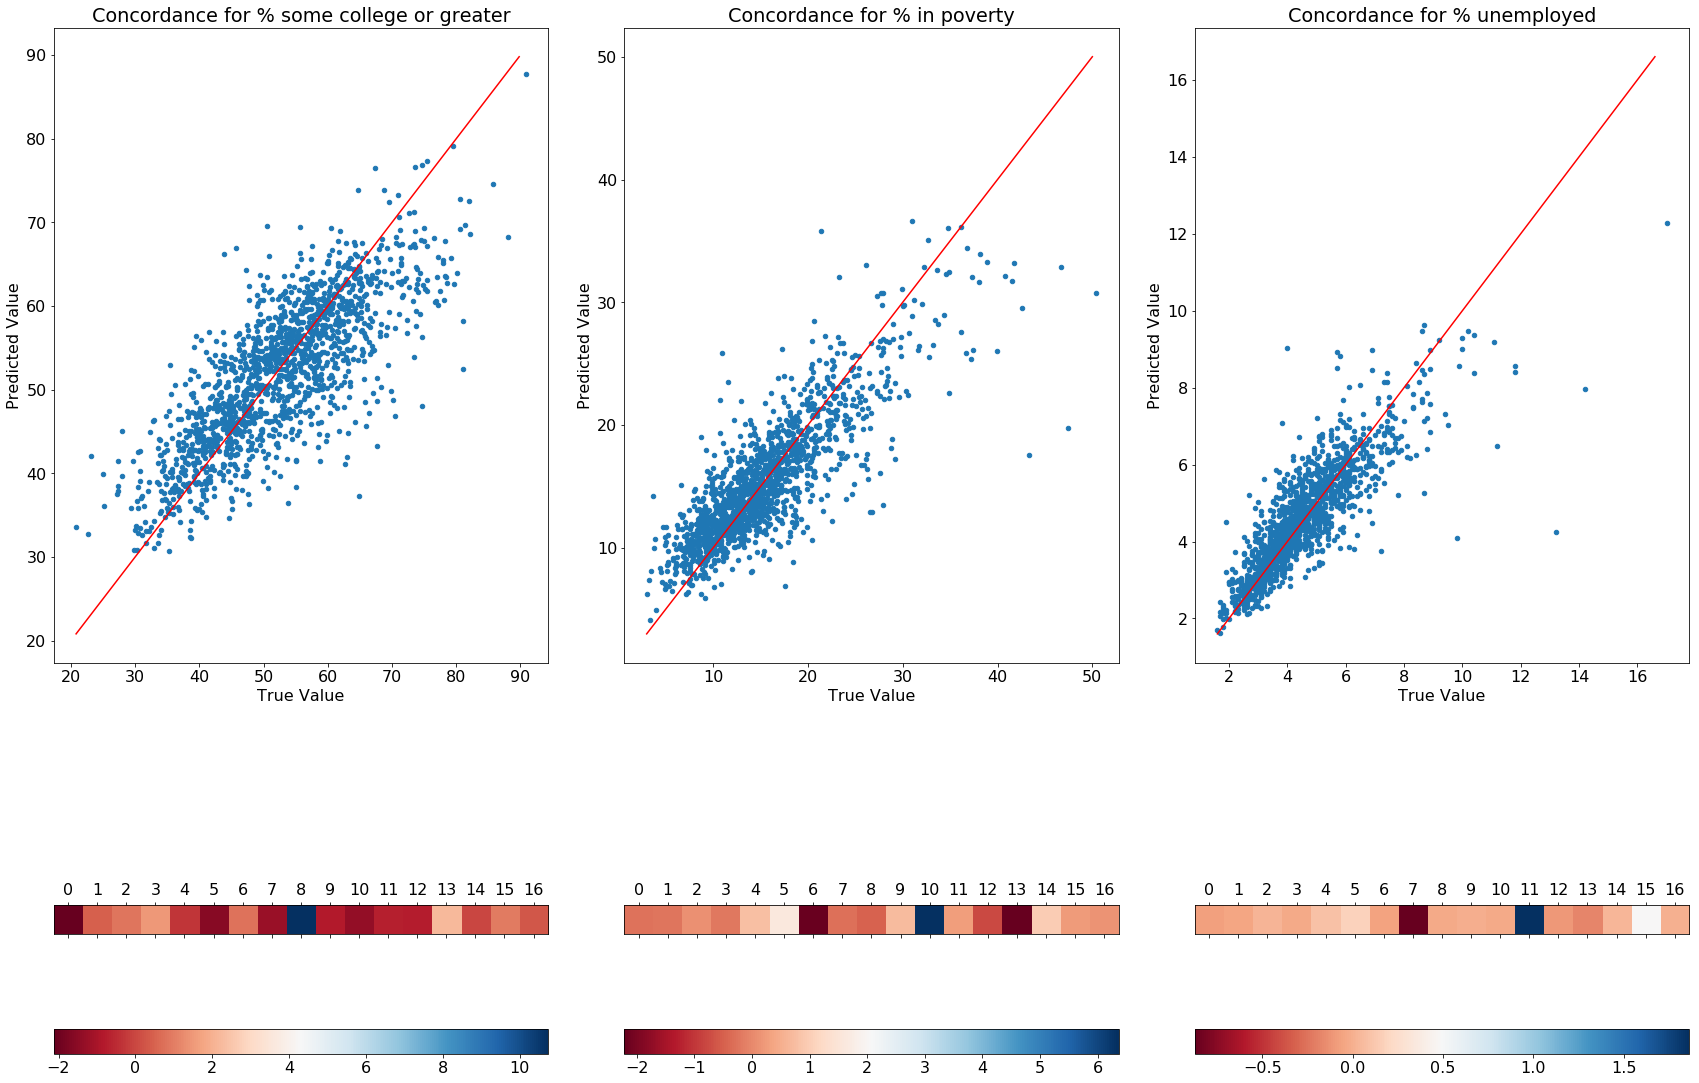

0 min education
1 min population
2 min poverty
3 min unemployment
4 max education
5 max population
6 max poverty
7 max unemployment
8 mean education
9 mean population
10 mean poverty
11 mean unemployment
12 std education
13 std population
14 std poverty
15 std unemployment
16 number of neighbors


In [68]:
plot_concordance(neighbor_data, labels)
for i in range(17):
    print(i, feature_to_name[i])

# Neighbor + Within-County Regression

In [69]:
data = pickle.load(open('data/processed_data/clean_regression_2017', 'rb'))
adj_list = pickle.load(open('data/processed_data/adj_list', 'rb'))
idxs = data[:, 0]

neighbor_data = []
labels = []
for i in idxs:
    if i not in adj_list:
        continue
    
    # Prepare within-county labels
    label_data = data[idxs == i][0][1:]
    label_data[3] = label_data[3] + label_data[2]
    label_data = label_data[3:]
    labels.append(label_data)
    
    # Prepare neighbor-county features
    neighbors = adj_list[i]
    neighbor_attributes = []
    for n in neighbors:
        if n not in idxs:
            continue
        d = data[idxs == n][0][1:]
        d[3] = d[3] + d[2]
        d = d[3:]
        neighbor_attributes.append(d)
    neighbor_attributes = np.array(neighbor_attributes)
    min_attributes = np.min(neighbor_attributes, axis=0)
    max_attributes = np.max(neighbor_attributes, axis=0)
    mean_attributes = np.mean(neighbor_attributes, axis=0)
    std_attributes = np.std(neighbor_attributes, axis=0)
    feature_vec = np.concatenate((min_attributes, max_attributes, mean_attributes, std_attributes, label_data, np.array([len(neighbors)])))
    neighbor_data.append(feature_vec)
    
neighbor_data = np.array(neighbor_data)
labels = np.array(labels)
print(neighbor_data.shape, labels.shape)

(3091, 21) (3091, 4)


In [70]:
label_to_name = {
    0: 'index',
    #1: '% less than HS diploma',
    #2: '% only HS diploma',
    #3: '% some college',
    1: '% some college or greater',
    2: 'population',
    3: '% in poverty',
    4: '% unemployed',
}

feature_to_name = {
    0: 'min education',
    1: 'min population',
    2: 'min poverty',
    3: 'min unemployment',
    4: 'max education',
    5: 'max population',
    6: 'max poverty',
    7: 'max unemployment',
    8: 'mean education',
    9: 'mean population',
    10: 'mean poverty',
    11: 'mean unemployment',
    12: 'std education',
    13: 'std population',
    14: 'std poverty',
    15: 'std unemployment',
    16: '% some college or greater',
    17: 'population',
    18: '% in poverty',
    19: '% unemployed',
    20: 'number of neighbors'
}

In [71]:
def do_regression(data, labels, num_folds=5, seed=1234):        
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        x = x[:, np.delete(np.arange(0, 21), i + 16)]
        y = labels[:, i]
        
        mses = []
        maes = []
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            mses.append(mean_squared_error(y_test, y_pred))
            maes.append(mean_absolute_error(y_test, y_pred))
        
        print('\n=== {} ==='.format(label_to_name[i + 1]))
        print('Mean Squared Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(mses), np.median(mses), np.std(mses), np.min(mses), np.max(mses)))
        print('Mean Absolute Error: mean = {}, median = {}, std = {}, min = {}, max = {}'.format(np.mean(maes), np.median(maes), np.std(maes), np.min(maes), np.max(maes)))
        print('Label stats: min = {}, max = {}, mean = {}, std = {}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [72]:
do_regression(neighbor_data, labels)


=== % some college or greater ===
Mean Squared Error: mean = 36.282270132605674, median = 32.87094969814059, std = 9.575944349538696, min = 26.79943525305377, max = 54.40615646176194
Mean Absolute Error: mean = 4.40155940863227, median = 4.3318802227448865, std = 0.24852362943019835, min = 4.063161443462197, max = 4.782192296314707
Label stats: min = 15.3, max = 90.8, mean = 51.71015852474927, std = 10.639074817876304

=== % in poverty ===
Mean Squared Error: mean = 9.417668415877984, median = 9.544805136228826, std = 1.2581530062545376, min = 7.599433847328573, max = 11.489626948736266
Mean Absolute Error: mean = 2.1632157946145445, median = 2.170807105368529, std = 0.09752509545681587, min = 1.9916225846654654, max = 2.29258995022145
Label stats: min = 3.0, max = 56.7, mean = 15.393303138142995, std = 6.246585903489967

=== % unemployed ===
Mean Squared Error: mean = 0.5439139774622553, median = 0.44115308400070385, std = 0.17650253188611476, min = 0.36680303927649144, max = 0.80545

In [87]:
def plot_concordance(data, labels, seed=1234):
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    idx = 0
    for i in range(labels.shape[1]):
        if label_to_name[i + 1] == 'population':
            continue
        
        kf = KFold(n_splits=2, shuffle=True, random_state=seed)
        # This does z-score normalization of data
        x = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
        x = x[:, np.delete(np.arange(0, 21), i + 16)]
        y = labels[:, i]
        
        for train_idx, test_idx in kf.split(x, y):
            x_train, y_train = x[train_idx], y[train_idx]
            x_test, y_test = x[test_idx], y[test_idx]
           
            model = LinearRegression(normalize=False, n_jobs=-1).fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            axes[0, idx].scatter(y_test, y_pred, s=20)
            axes[0, idx].plot(np.arange(np.min(y_test), np.max(y_test)), np.arange(np.min(y_test), np.max(y_test)), color='red')
            axes[0, idx].set_xlabel('True Value')
            axes[0, idx].set_ylabel('Predicted Value')
            axes[0, idx].set_title('Concordance for {}'.format(label_to_name[i + 1]))
            
            im = axes[1, idx].matshow(model.coef_[np.newaxis, :], cmap='RdBu')
            plt.colorbar(im, ax=axes[1, idx], orientation='horizontal')
            axes[1, idx].set_yticks([], [])
            other_idxs = [str(k) for k in range(16, 21)]
            other_idxs.remove(str(i + 16))
            axes[1, idx].set_xticks(np.arange(0, 20))
            axes[1, idx].set_xticklabels([str(k) for k in range(16)] + other_idxs)
            
            idx += 1
            break
    plt.tight_layout()
    plt.show()

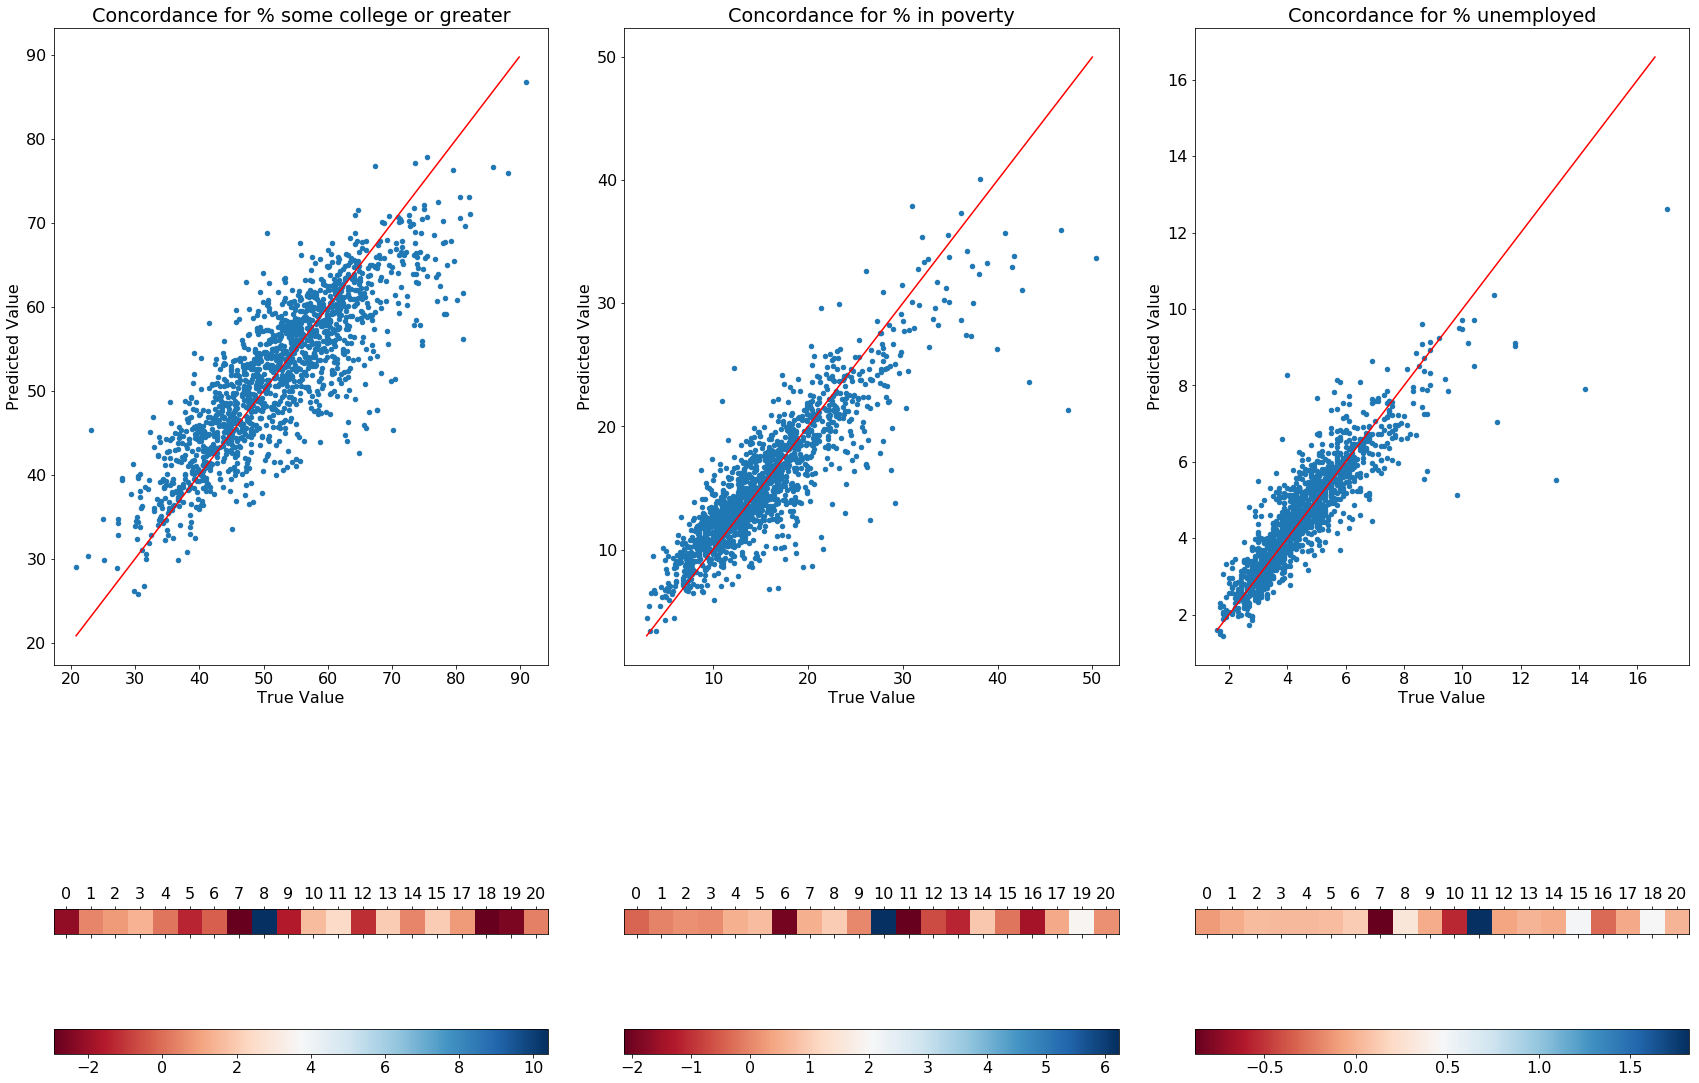

0 min education
1 min population
2 min poverty
3 min unemployment
4 max education
5 max population
6 max poverty
7 max unemployment
8 mean education
9 mean population
10 mean poverty
11 mean unemployment
12 std education
13 std population
14 std poverty
15 std unemployment
16 % some college or greater
17 population
18 % in poverty
19 % unemployed
20 number of neighbors


In [90]:
plot_concordance(neighbor_data, labels)
for i in range(21):
    print(i, feature_to_name[i])

# Null Model Regression